In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.special import expit, logit
import scipy.stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.gof import powerdiscrepancy # modified locally, use 0.14 or see https://github.com/statsmodels/statsmodels/issues/8558
import plotly.graph_objects as go


# Estimating the model's parameters using Maximum likelihood estimation

## The Model

### Predictions

In [14]:

def compute_t(ρ, α, β):
    """Generate t - eq .3 - the true incidence of left-handedness

    From main text:
    F_DR is the final equilibrium frequency of right-handers with allele D fixed
    We need F_DL = 1 - F_DR
    """
    if np.isclose(β, 0): 
        FDR = (1 - 2 * α + 2 * ρ) / (2 * (1 - 2 * α))  # eq 3a
    else:
        Δ = 4 * α * α - 4 * α + 4 * β * β + 1 + 8 * β * ρ
        FDR = (2 * α + 2 * β - 1 + np.sqrt(Δ)) / (4 * β)  # eq 3
        assert 0 < 1 - FDR < 1, ("t is the problem! t = ", 1-FDR)
    return 1 - FDR


In [15]:
def validate(θ):
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if (not 0 <= ρ <= 1) or (not 0 <= α <= 1) or (not 0 <= β <= 1) or (ρ + α >= 0.5) or (ρ - α > 0.5) or (ρ + β > 0.5): 
        return False
    return True

In [16]:
def compute_T(ρ, α, β):
    """Generate T - column DD in Table 1

    From Appendix 3:
    T is a 3 x 2 matrix of p(Ht | Ht x Ht) entries -
    probability of a truly H child from a mating where parents are truly H
    """
    return np.array([
        # R           L
        [0.5 + ρ + α, 1 - (0.5 + ρ + α)],  # RxR
        [0.5 + ρ + β, 1 - (0.5 + ρ + β)],  # RxL
        [0.5 + ρ - α, 1 - (0.5 + ρ - α)]  # LxL
    ])

### Adjustments

In [17]:
global adjust 
adjust = False

In [18]:
# def compute_mp_mo(D):
#     # assert D.ndim == 1, ("D.ndim = ",D.ndim) 
#     # D 0 R|RxR 1 L|RxR 2 R|RxL 3 L|RxL 4 R|LxL 5 L|LxL
#     mp = (D[2] + D[3] + 2*D[4] + 2*D[5]) / (2 * D.sum())
#     mo = (D[1] + D[3] + D[5]) / D.sum()
#     return mp, mo

In [19]:

def compute_P(mp, t):

    if mp > t:

        u = (mp - t) / mp
        assert 0 <= u < 1, "u is the problem"
        
        P = np.array([
            [1, 0, 0],
            [u, 1 - u, 0],
            [u * u, 2 * u * (1 - u), (1 - u) * (1 - u)]
        ])

    if mp < t: #changed from "else"

        v = (t - mp) / (1 - mp)  # fixed from: (t - mp)/t
        # v= t/1-mp
        assert 0 <= v <= 1, "v is the problem"

        P = np.array([
            [(1 - v) * (1 - v), 2 * v * (1 - v), v * v],
            [0, 1 - v, v],
            [0, 0, 1]
        ])

    if mp == t: #added
        P = np.array([
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
            ])
        assert ((0 <= P) & (P <= 1)).all(), "P is the problem"
        
    return P

In [20]:

def compute_O(mo, t):

    if mo > t:

        w = (mo - t) / (1 - t)
        assert 0 <= w < 1, "w is the problem"

        O = np.array([
            [1 - w, w],
            [0, 1]
        ])
        
    if mo < t: #changed from "else"

        x = 1 - (mo / t)
        assert 0 <= x <= 1, "x is the problem"
        
        O = np.array([
            [1, 0],
            [x, 1 - x]
        ])

    if mo == t: #added
        O = np.array([
            [1, 0],
            [0, 1]
            ])
        assert ((0 <= O) & (O <= 1)).all(), "O is the problem"

    return O

In [21]:
def compute_M(T, P, O):
    M = P @ T @ O
    assert ((0 <= M) & (M <= 1)).all(), "M is the problem"
    return M

### log-likelihood function

In [22]:
def log_likelihood(θ, Data):
    
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if not validate(θ):
        return -np.inf


    S = 0

    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0 <= T) & (T <= 1)).all(), "T is the problem"
    assert 0 <= t <= 1, "t is the problem"


    if adjust == True:

        """" estimation using the matrix M"""
        
        for index, dataset in enumerate(Data):
            mp_idx = mp[index]
            mo_idx = mo[index]
            assert 0 < mp_idx < 1, "mp is not right"
            assert 0 < mo_idx < 1, "mo is not right"

            P = compute_P(mp_idx, t)
            assert ((0 <= P) & (P <= 1)).all()
            
            O = compute_O(mo_idx, t)
            assert ((0 <= O) & (O <= 1)).all()
            
            M = compute_M(T, P, O)
            assert ((0 <= M) & (M <= 1)).all()

            logM = np.log(M) 

            S += (
                    dataset[0] * logM[0, 0] +  # R|RxR
                    dataset[1] * logM[0, 1] +  # L|RxR
                    dataset[2] * logM[1, 0] +  # R|RxL
                    dataset[3] * logM[1, 1] +  # L|RxL
                    dataset[4] * logM[2, 0] +  # R|LxL
                    dataset[5] * logM[2, 1]    # L|LxL
                )


    if adjust == False:

        """ estimation using the matrix T """

        for dataset in Data:
            logT = np.log(T) 

            S += (
                    dataset[0] * logT[0, 0] +  # R|RxR
                    dataset[1] * logT[0, 1] +  # L|RxR
                    dataset[2] * logT[1, 0] +  # R|RxL
                    dataset[3] * logT[1, 1] +  # L|RxL
                    dataset[4] * logT[2, 0] +  # R|LxL
                    dataset[5] * logT[2, 1]    # L|LxL
            )

    return S

# Data

In [23]:
#    R|RxR  L|RxR  R|RxL  L|RxL  R|LxL  L|LxL
#     0     1      2      3       4     5

D = [
    [841,  115,   113,   54,    1,    7],   # Ramaley 1913, paper says it does not fit
    [6917, 308,   411,   53,    18,    7],  # Chamberlain 1928
    [1842, 151,   140,   34,    5,     6],  # Rife 1940
    [140,  34,    33,    20,    8,     2],  # Merrell 1975
    [6206, 669,   471,   125,   5,     1],  # Annett 1973
    [154,  11,    31,    9,     0,     0],  # Ferronato et al. 1947
    [232,  17,    41,    7,     3,     1],  # Mascie-Taylor (unpub, in McManus 1985)
    [1060, 144,   122,   46,    3,     4],  # Chaurasia & Groswani (unpub, in McManus 1985)
    [1656, 130,   170,   40,    4,     0],  # Annett 1978
    [303,  37,    45,    15,    0,     0],  # Carter-Saltzmann 1980
    [315,  68,    57,    16,    0,     0],  # Coren & Porac 1980
    [848,  211,   325,   150,   30,   22],  # McGee & Cozad 1980
    [58,   9,     14,    5,     0,     0],  # McManus 1985 ICM1
    [134,  15,    17,    9,     1,     0],  # McManus 1985 ICM2prop
    [74,   4,     6,     2,     0,     0],  # McManus 1985 ICM2mat
    [86,   4,     8,     1,     0,     0],  # McManus 1985 ICM2pat
    [1729, 173,   281,   63,    8,     3]   # Leiber & Axelrod 1981
]
D = np.array(D)


In [24]:
"""Observed frequency of left handers in parents generation"""

mp = [
    0.0803,   # Ramaley 1913, paper says it does not fit
    0.0356,  # Chamberlain 1928
    0.0524,  # Rife 1940
    0.1553,  # Merrell 1957
    0.0440,  # Annett 1973
    0.0986,  # Ferronato et al. 1947
    0.0930,  # Mascie-Taylor (unpub, in McManus 1985)
    0.1040,  # Chaurasia & Groswani (unpub, in McManus 1985)
    0.0547,  # Annett 1978
    0.0760,  # Carter-Saltzmann 1980
    0.0838,  # Coren & Porac 1980
    0.1802,  # McGee & Cozad 1980
    0.1105,  # McManus 1985 ICM1
    0.0795,  # McManus 1985 ICM2prop
    0.0465,  # McManus 1985 ICM2mat
    0.0455,  # McManus 1985 ICM2pat
    0.0811 # Leiber & Axelrod 1981
]

mp = np.array(mp)


In [25]:
"""Observed frequency of left handers in offspring generation"""
mo = [
    0.1556,   # Ramaley 1913, paper says it does not fit
    0.0477,  # Chamberlain 1928
    0.0877,  # Rife 1940
    0.2362,  # Merrell 1957
    0.1063,  # Annett 1973
    0.0976,  # Ferronato et al. 1947
    0.0831,  # Mascie-Taylor (unpub, in McManus 1985)
    0.1407,  # Chaurasia & Groswani (unpub, in McManus 1985)
    0.0850,  # Annett 1978
    0.1320,  # Carter-Saltzmann 1980
    0.1838,  # Coren & Porac 1980
    0.2457,  # McGee & Cozad 1980
    0.1628,  # McManus 1985 ICM1
    0.1364,  # McManus 1985 ICM2prop
    0.0698,  # McManus 1985 ICM2mat
    0.0505,  # McManus 1985 ICM2pat
    0.1059 # Leiber & Axelrod 1981
]

mo=np.array(mo)


# Laland's 1995 findings

In [26]:
# using 3 parameters
θ_1995 = np.array([0.267, 0.148,  0.012])
logL_1995 = log_likelihood(θ_1995, D)
FDL_θ_1995 = compute_t(*θ_1995)

print("Laland 1995 3D:", '\n',
      'ρ=0.267, α=0.148, β=0.012', '\n', # what is the logL in their paper?
      "F_DL= {:.2f}%".format(FDL_θ_1995*100),'\n',
      "logL= {:.2f}".format(logL_1995))


Laland 1995 3D: 
 ρ=0.267, α=0.148, β=0.012 
 F_DL= 11.72% 
 logL= -8826.64


In [27]:
# using 2 parameters
θ_19952d = np.array([0.277, 0.138, 0])
logL_19952d = log_likelihood(θ_19952d,D)
FDL_θ_19952d = compute_t(*θ_19952d)

print("Laland 1995 2D:", '\n',
      'ρ=0.277, α=0.138, β=0', '\n',
      "F_DL= {:.2f}%".format(FDL_θ_19952d*100),'\n',
      "logL= {:.2f}".format(logL_19952d))

Laland 1995 2D: 
 ρ=0.277, α=0.138, β=0 
 F_DL= 11.74% 
 logL= -8826.79


# Maximum Likelihood Estimation

In [28]:
def neg_log_likelihood(θ, Data):
    return -log_likelihood(θ, Data)

## adjust = False

In [17]:
adjust = False

### Nelder-Mead

In [18]:
def fit(n_parameters,Data):
    θ_hat = None
    logL = -np.inf
    for _ in range(1000):
        θ0 = np.random.random(n_parameters)/(n_parameters)
        result = opt.minimize(neg_log_likelihood, θ0, args=(Data,), method='Nelder-Mead')
        if -result.fun > logL:
            logL = -result.fun
            θ_hat = result.x
            print(θ_hat, logL, flush=True)
    return θ_hat, logL

#### 3D (rho, alpha, beta)

In [19]:
θ_Nelder_Mead_3D_T, Nelder_Mead_logL_3D_T = fit(3, D)

[0.26686811 0.14810007 0.01195278] -8826.642861455312
[0.26680496 0.14815866 0.01199049] -8826.642853017827


/Users/ronykarstadt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


[0.26682029 0.14814081 0.01198885] -8826.642852812964
[0.26680512 0.14815695 0.01199797] -8826.642852672625
[0.26685034 0.14811173 0.01194388] -8826.6428522967
[0.26681955 0.14814186 0.01197796] -8826.642852106434
[0.26681789 0.14814386 0.01198134] -8826.642852008817


In [20]:
print("MLE using Nelder-Mead (3 parameters):",'\n')
print("logL= {:.2f}".format(log_likelihood(θ_Nelder_Mead_3D_T, D)),'\n',
    "ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_Nelder_Mead_3D_T),'\n')
print("α+ρ<0.5:",θ_Nelder_Mead_3D_T[:2].sum()<0.5,'\n')
print("F_DL= {:.2f}%".format(compute_t(*θ_Nelder_Mead_3D_T)*100))
print("-"*30,"\nLaland 1995:\n"),
# print("logL= {:.2f}".format(log_likelihood(θ_1995, D)),'\n'),
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_1995),'\n')
print("F_DL= {:.2f}%".format(compute_t(*θ_1995)*100))

MLE using Nelder-Mead (3 parameters): 

logL= -8826.64 
 ρ=0.267, α=0.148, β=0.012 

α+ρ<0.5: True 

F_DL= 11.73%
------------------------------ 
Laland 1995:

ρ=0.267, α=0.148, β=0.012 

F_DL= 11.72%


#### 2D (rho, alpha)

In [21]:
θ_Nelder_Mead_2D_T, Nelder_Mead_logL_2D_T = fit(2, D)

[0.27734843 0.13765191] -8826.792770973852
[0.27731121 0.13769842] -8826.792766073853
[0.27732207 0.13768169] -8826.792758773085
[0.27731799 0.13768375] -8826.792757848158


In [22]:
print("MLE using Nelder-Mead (2 parameters):",'\n')
print("logL= {:.2f}".format(log_likelihood(θ_Nelder_Mead_2D_T, D)))
print("ρ={:.3f}, α={:.3f}".format(*θ_Nelder_Mead_2D_T),'\n')
print("α+ρ<0.5:",θ_Nelder_Mead_2D_T[:2].sum()<0.5,'\n')
print("F_DL= {:.2f}%".format(compute_t(*θ_Nelder_Mead_2D_T,β=0)*100))


print("-"*30,"\nLaland 1995:\n")
# print("logL= {:.2f}".format(log_likelihood(θ_19952d, D)),'\n'),
print("ρ={:.3f}, α={:.3f}".format(*θ_19952d),'\n')
print("F_DL= {:.2f}%".format(compute_t(*θ_19952d)*100))

MLE using Nelder-Mead (2 parameters): 

logL= -8826.79
ρ=0.277, α=0.138 

α+ρ<0.5: True 

F_DL= 11.73%
------------------------------ 
Laland 1995:

ρ=0.277, α=0.138 

F_DL= 11.74%


### Grid search 

In [23]:
""" Build a grid size pts^3"""
pts = 1000
ρs = np.linspace(0, 1, pts)
αs = np.linspace(0, 1, pts)
βs = np.linspace(0, 1, pts)

grid_3D = np.meshgrid(ρs, αs, βs)
grid_2D= np.meshgrid(ρs, αs)

In [24]:
""" define plots variables """

font_size_=15
tick_size_ =15
marker_size_ = 9
cont_color= 'magma'
line_color = 'gray'
trans = 0.2

#### 3D (rho, alpha, beta)

In [25]:
grid_logL = np.zeros((pts, pts, pts))

for i, ρ_ in enumerate(ρs):
    print(i, end=' ', flush=True)
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            θ_ = ρ_, α_, β_
            grid_logL[i,j,k] = log_likelihood(θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            try: 
                grid_logL[i,j,k] = grid_logL[i,j,k] 
            except Exception as e:
                    print("Problem with", ρ_, α_, β_, ":", e)
                    grid_logL[i,j,k] = -np.inf



imax = np.unravel_index(np.argmax(grid_logL), grid_logL.shape) 
θ_grid=(ρs[imax[0]], αs[imax[1]], βs[imax[2]]) 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [26]:
θ_grid_3par_T = θ_grid
grid_logs_3par_T = grid_logL
grid_logs_3par_T_max = grid_logL.max()

In [27]:
# np.save(file='Grid_3D_T', arr=grid_logs_3par_T)

In [28]:
print("Grid 3D MLE estimate: \n")
print("logL={:.5f}".format(log_likelihood(θ_grid_3par_T, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_grid_3par_T))
print("α+ρ<0.5:",(θ_grid_3par_T[0] + θ_grid_3par_T[1]) < 0.5)
print("F_DL= {:.2f}%".format(compute_t(*θ_grid_3par_T)*100))

Grid 3D MLE estimate: 

logL=-8826.90552
ρ=0.263, α=0.152, β=0.020
α+ρ<0.5: True
F_DL= 11.72%


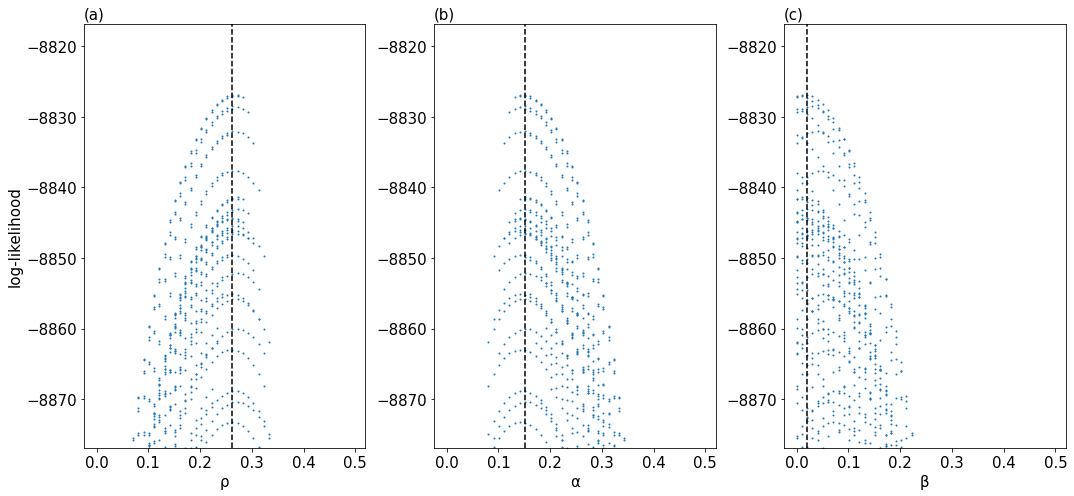

In [29]:
""" scatterplot """

scat_3D_T, axes = plt.subplots(1, 3, figsize=(15,7))

#rho
ax = axes[0]
ax.plot(grid_3D[1].ravel(), grid_logs_3par_T.ravel(), '.', markersize=2) #grid[0] -> canged to grid[1]
ax.axvline(θ_grid_3par_T[0], color='k', ls='--')
ax.set_ylim(grid_logs_3par_T.max()-50, grid_logs_3par_T.max()+10)
ax.set_xlabel('ρ', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_ylabel('log-likelihood', fontsize= font_size_)
ax.set_title('(a)', loc='left', size=font_size_)

#alpha
ax = axes[1]
ax.plot(grid_3D[0].ravel(), grid_logs_3par_T.ravel(), '.', markersize=2) #grid[1]-> changed to grid[0]
ax.axvline(θ_grid_3par_T[1],color='k', ls='--')
ax.set_ylim(grid_logs_3par_T.max()-50, grid_logs_3par_T.max()+10)
ax.set_xlabel('α', fontsize= font_size_)
ax.tick_params(axis = 'both', which = 'major', labelsize = tick_size_)
ax.set_title('(b)', loc ='left', size = font_size_)

#beta
ax = axes[2]
ax.plot(grid_3D[2].ravel(), grid_logs_3par_T.ravel(), '.', markersize=2) #grid[1]-> changed to grid[0]
ax.axvline(θ_grid_3par_T[2], color='k', ls='--')
ax.set_ylim(grid_logs_3par_T.max()-50, grid_logs_3par_T.max()+10)
ax.set_xlabel('β', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(c)', loc='left', size=font_size_)

scat_3D_T.tight_layout()



/var/folders/r8/p53qs7x13xsgkhtwh7r_0_qr0000gn/T/ipykernel_4167/1354250943.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  cont_3D_T.tight_layout()


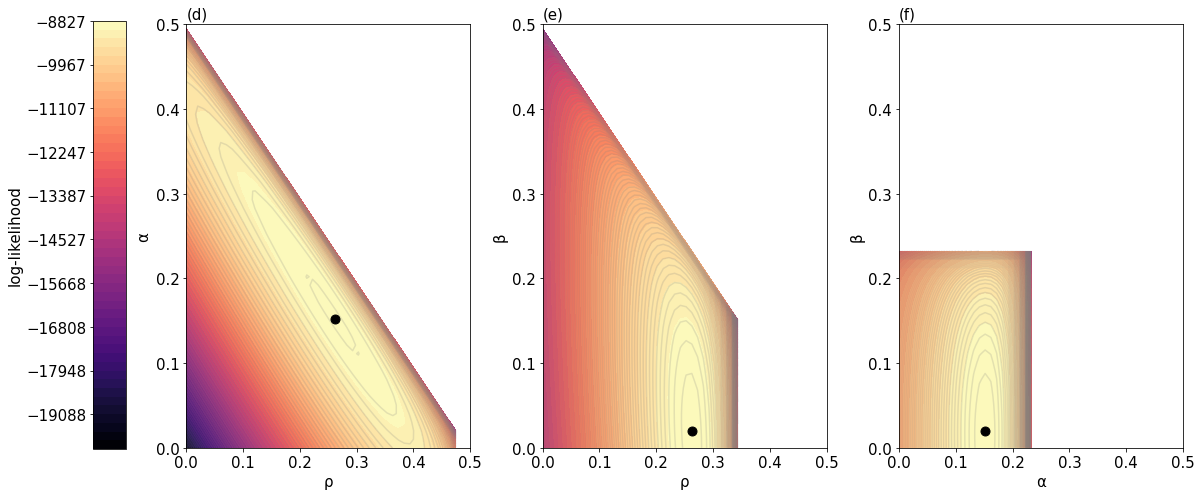

In [30]:
""" Contour plot """ 

cont_3D_T, axes = plt.subplots(1, 3, figsize= (15,7))

levels =np.linspace(-20000, grid_logs_3par_T.max())
levels_line = 100

ax = axes[0]
pco = ax.contourf(ρs, αs, grid_logs_3par_T[:,:,βs==θ_grid_3par_T[2]].squeeze().T, cmap=cont_color, levels=levels)
ax.contour(ρs, αs, grid_logs_3par_T[:,:,βs==θ_grid_3par_T[2]].squeeze().T,  colors=line_color, levels= levels_line, linestyles='solid', alpha= trans)
ax.plot(θ_grid_3par_T[0],θ_grid_3par_T[1], 'ok',markersize=marker_size_ )
ax.set(xlim=(0, 0.5), ylim=(0,0.5))
ax.set_xlabel('ρ', fontsize= font_size_)
ax.set_ylabel('α', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(d)',loc='left', size=font_size_)


ax = axes[1]
pco = ax.contourf(ρs, βs, grid_logs_3par_T[:,αs==θ_grid_3par_T[1],:].squeeze().T, cmap=cont_color, levels=levels)
ax.contour(ρs, βs, grid_logs_3par_T[:,αs==θ_grid_3par_T[1],:].squeeze().T,  colors=line_color, levels= levels_line, linestyles='solid', alpha= trans)
ax.plot(θ_grid_3par_T[0],θ_grid_3par_T[2],'ok', markersize=marker_size_ )
ax.set(xlim=(0, 0.5), ylim=(0,0.5))
ax.set_xlabel('ρ', fontsize= font_size_)
ax.set_ylabel('β', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(e)',loc='left', size=font_size_)


ax = axes[2]
pco = ax.contourf(αs, βs, grid_logs_3par_T[ρs==θ_grid_3par_T[0],:,:].squeeze().T, cmap=cont_color, levels=levels)
ax.contour(αs, βs, grid_logs_3par_T[ρs==θ_grid_3par_T[0],:,:].squeeze().T,  colors=line_color, levels= levels_line, linestyles='solid', alpha= trans)
ax.plot(θ_grid_3par_T[1],θ_grid_3par_T[2],'ok',markersize=marker_size_)
ax.set(xlim=(0, 0.5), ylim=(0,0.5))
ax.set_xlabel('α', fontsize= font_size_)
ax.set_ylabel('β', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(f)',loc='left', size=font_size_)

cax = cont_3D_T.add_axes([-0.030, 0.1, 0.03, 0.85])
cbar = plt.colorbar(pco, cax=cax, label='log-likelihood')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize= tick_size_)
cbar.ax.set_ylabel('log-likelihood', fontsize= font_size_)


cont_3D_T.tight_layout()

#### 2D (rho, alpha)

In [84]:
grid_logL = np.zeros((pts, pts))

for i, ρ_ in enumerate(ρs):
    print(i, end=' ', flush=True)
    for j, α_ in enumerate(αs):
        θ_ = ρ_, α_
        grid_logL[i,j] = log_likelihood(θ_, D) 

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        try: 
            grid_logL[i,j] = grid_logL[i,j] 
        except Exception as e:
                print("Problem with", ρ_, α_, ":", e)
                grid_logL[i,j] = -np.inf

imax = np.unravel_index(np.argmax(grid_logL), grid_logL.shape) 
θ_grid = (ρs[imax[0]], αs[imax[1]], 0)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [85]:
θ_grid_2par_T = θ_grid
grid_logs_2par_T = grid_logL
grid_logs_2par_T_max = grid_logL.max()

In [ ]:
# np.save(file='Grid_2par_T', arr= grid_logs_2par_T)

In [88]:
print("Grid 2D MLE estimate: \n")
print("logL={:.5f}".format(log_likelihood(θ_grid_2par_T, D)))
print("ρ={:.3f}, α={:.3f}, β=0".format(*θ_grid_2par_T))
print("α+ρ<0.5:",(θ_grid_2par_T[0]+θ_grid_2par_T[1])<0.5)
print("F_DL= {:.2f}%".format(compute_t(*θ_grid_2par_T)*100))

Grid 2D MLE estimate: 

logL=-8827.10653
ρ=0.273, α=0.141, β=0
α+ρ<0.5: True
F_DL= 11.97%


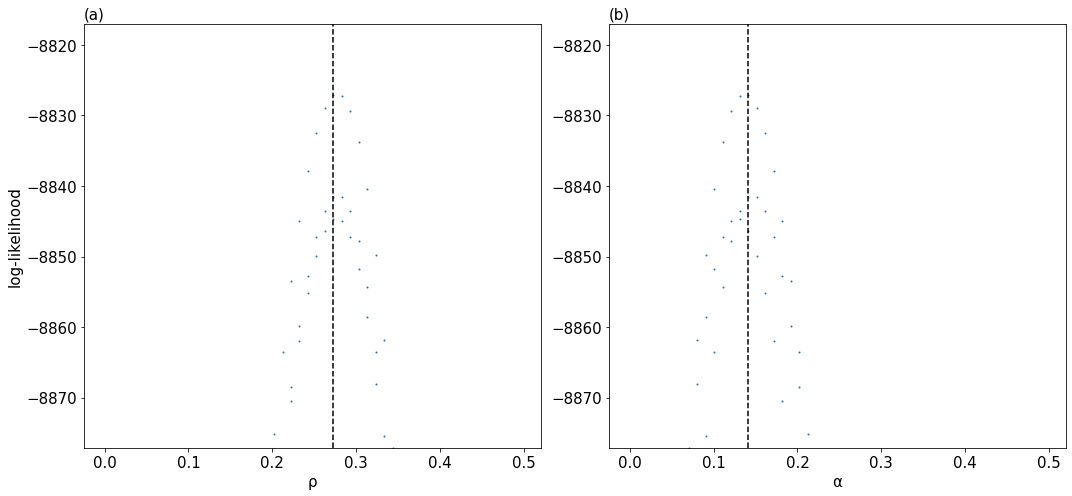

In [111]:
""" scatterplot """ 

scat_2D_T, axes = plt.subplots(1, 2, figsize= (15,7))

# rho
ax = axes[0]
ax.plot(grid_2D[1].ravel(), grid_logs_2par_T.ravel(), '.', markersize=2) 
ax.axvline(θ_grid_2par_T[0], color='k', ls='--')
ax.set_ylim(grid_logs_2par_T.max()-50, grid_logs_2par_T.max()+10)
ax.set_xlabel('ρ', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_ylabel('log-likelihood', fontsize= font_size_)
ax.set_title('(a)', loc='left', size=font_size_)

# alpha
ax = axes[1]
ax.plot(grid_2D[0].ravel(), grid_logs_2par_T.ravel(), '.', markersize=2) 
ax.axvline(θ_grid_2par_T[1],color='k', ls='--')
ax.set_ylim(grid_logs_2par_T.max()-50, grid_logs_2par_T.max()+10)
ax.set_xlabel('α', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(b)', loc='left', size=font_size_)

scat_2D_T.tight_layout()

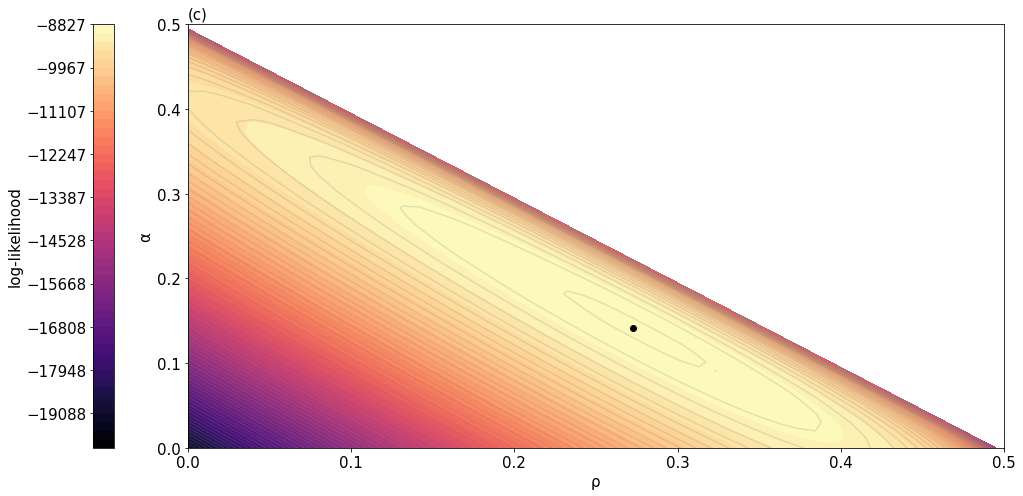

In [113]:
""" Contour plot """ 

cont_2D_T, axes = plt.subplots(1, figsize= (15,7))


levels =np.linspace(-20000, grid_logs_2par_T.max())
levels_line = 100

ax = axes
pco = ax.contourf(ρs, αs, grid_logs_2par_T[:,:,].squeeze().T, cmap=cont_color, levels=levels)
ax.contour(ρs, αs, grid_logs_2par_T[:,:,].squeeze().T, colors=line_color, levels= levels_line, linestyles='solid', alpha= trans)
ax.plot(θ_grid_2par_T[0],θ_grid_2par_T[1],'ok', markersize=marker_size_)
ax.set(xlim=(0, 0.5), ylim=(0,0.5))
ax.set_xlabel('ρ', fontsize= font_size_)
ax.set_ylabel('α', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(c)', loc='left', size=font_size_)

cbar = plt.colorbar(pco, label= 'log-likelihood', location='left', pad=0.07)
cbar.ax.tick_params(labelsize= tick_size_)
cbar.ax.set_ylabel('log-likelihood', fontsize= font_size_)


cont_2D_T.tight_layout()


## adjust = True

In [29]:
adjust = True

In [30]:
adjust == True

True

### Nelder-Mead

In [19]:
def fit(n_parameters,Data):
    θ_hat = None
    logL = -np.inf
    for _ in range(1000):
        θ0 = np.random.random(n_parameters)/(n_parameters)
        result = opt.minimize(neg_log_likelihood, θ0, args=(Data,), method='Nelder-Mead')
        if -result.fun > logL:
            logL = -result.fun
            θ_hat = result.x
            print(θ_hat, logL, flush=True)
    return θ_hat, logL

#### 3D (rho, alpha, beta)

In [20]:
θ_Nelder_Mead_3D_M, Nelder_Mead_logL_3D_M = fit(3, D)

[6.00234791e-05 4.87316256e-01 4.71612283e-03] -8593.641042054544
[2.97831574e-01 1.28604639e-01 8.72781050e-08] -8573.089199395876
[0.20723856 0.20340357 0.04203769] -8566.939423556005


/opt/tljh/user/lib/python3.9/site-packages/scipy/optimize/_optimize.py:790: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


[0.20724973 0.20339574 0.04203569] -8566.93942332039
[0.20722961 0.20341186 0.04205591] -8566.939423193862
[0.20724359 0.20340186 0.04204846] -8566.939423140298


In [21]:
print("MLE using Nelder-Mead (3 parameters):",'\n')
print("logL= {:.2f}".format(log_likelihood(θ_Nelder_Mead_3D_M, D)),'\n',
    "ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_Nelder_Mead_3D_M),'\n')
print("α+ρ<0.5:",θ_Nelder_Mead_3D_M[:2].sum()<0.5,'\n')
print("F_DL= {:.2f}%".format(compute_t(*θ_Nelder_Mead_3D_M)*100))
print("-"*30,"\nLaland 1995:\n"),
# print("logL= {:.2f}".format(log_likelihood(θ_1995, D)),'\n'),
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_1995),'\n')
print("F_DL= {:.2f}%".format(compute_t(*θ_1995)*100))

MLE using Nelder-Mead (3 parameters): 

logL= -8566.94 
 ρ=0.207, α=0.203, β=0.042 

α+ρ<0.5: True 

F_DL= 13.42%
------------------------------ 
Laland 1995:

ρ=0.267, α=0.148, β=0.012 

F_DL= 11.72%


#### 2D (rho, alpha, beta)

In [22]:
θ_Nelder_Mead_2D_M, Nelder_Mead_logL_2D_M = fit(2, D)

[0.04728944 0.35637539] -8593.642081662492
[0.23892382 0.17199748] -8567.529455983677


In [23]:
print("MLE using Nelder-Mead (2 parameters):",'\n')
print("logL= {:.2f}".format(log_likelihood(θ_Nelder_Mead_2D_M, D)))
print("ρ={:.3f}, α={:.3f}".format(*θ_Nelder_Mead_2D_M),'\n')
print("α+ρ<0.5:",θ_Nelder_Mead_2D_M[:2].sum()<0.5,'\n')
print("F_DL= {:.2f}%".format(compute_t(*θ_Nelder_Mead_2D_M,β=0)*100))


print("-"*30,"\nLaland 1995:\n")
# print("logL= {:.2f}".format(log_likelihood(θ_19952d, D)),'\n'),
print("ρ={:.3f}, α={:.3f}".format(*θ_19952d),'\n')
print("F_DL= {:.2f}%".format(compute_t(*θ_19952d)*100))

MLE using Nelder-Mead (2 parameters): 

logL= -8567.53
ρ=0.239, α=0.172 

α+ρ<0.5: True 

F_DL= 13.58%
------------------------------ 
Laland 1995:

ρ=0.277, α=0.138 

F_DL= 11.74%


### Grid search

In [31]:
""" Build a grid size pts^3"""
pts = 1000
ρs = np.linspace(0, 1, pts)
αs = np.linspace(0, 1, pts)
βs = np.linspace(0, 1, pts)

grid_3D = np.meshgrid(ρs, αs, βs)
grid_2D= np.meshgrid(ρs, αs)

In [32]:
""" define plots variables """

font_size_=15
tick_size_ =15
marker_size_ = 9
cont_color= 'magma'
line_color = 'gray'
trans = 0.2

#### 3D (rho, alpha, beta)

In [33]:
grid_logL = np.zeros((pts, pts, pts))

for i, ρ_ in enumerate(ρs):
    print(i, end=' ', flush=True)
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            θ_ = ρ_, α_, β_
            grid_logL[i,j,k] = log_likelihood(θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            try: 
                grid_logL[i,j,k] = grid_logL[i,j,k] 
            except Exception as e:
                    print("Problem with", ρ_, α_, β_, ":", e)
                    grid_logL[i,j,k] = -np.inf



imax = np.unravel_index(np.argmax(grid_logL), grid_logL.shape) 
θ_grid=(ρs[imax[0]], αs[imax[1]], βs[imax[2]]) 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [34]:
θ_grid_3par_M = θ_grid
grid_logs_3par_M = grid_logL
grid_logs_3par_M_max = grid_logL.max()

In [35]:
# np.save(file='Grid_3D_M', arr=grid_logs_3par_M)

In [36]:
print("Grid 3D MLE estimate: \n")
print("logL={:.5f}".format(log_likelihood(θ_grid_3par_M, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_grid_3par_M))
print("α+ρ<0.5:",(θ_grid_3par_M[0] + θ_grid_3par_M[1]) < 0.5)
print("F_DL= {:.2f}%".format(compute_t(*θ_grid_3par_M)*100))

Grid 3D MLE estimate: 

logL=-8566.94041
ρ=0.207, α=0.203, β=0.042
α+ρ<0.5: True
F_DL= 13.44%


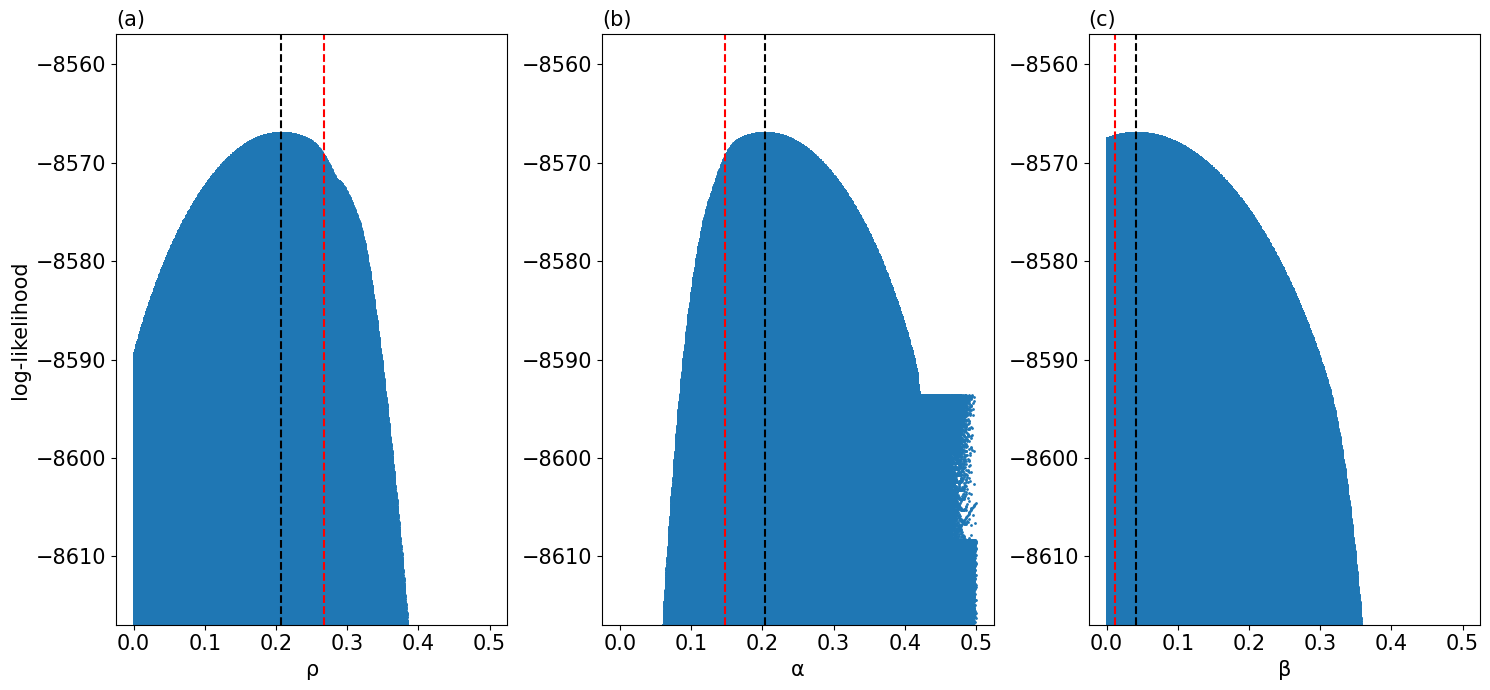

In [37]:
""" scatterplot """


scat_3D_M, axes = plt.subplots(1, 3, figsize=(15,7))

#rho
ax = axes[0]
ax.plot(grid_3D[1].ravel(), grid_logs_3par_M.ravel(), '.', markersize=2) #grid[0] -> canged to grid[1]
ax.axvline(θ_grid_3par_M[0], color='k', ls='--')
ax.axvline(θ_1995[0], color='r', ls='--')
ax.set_ylim(grid_logs_3par_M.max()-50, grid_logs_3par_M.max()+10)
ax.set_xlabel('ρ', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_ylabel('log-likelihood', fontsize= font_size_)
ax.set_title('(a)', loc='left', size=font_size_)

#alpha
ax = axes[1]
ax.plot(grid_3D[0].ravel(), grid_logs_3par_M.ravel(), '.', markersize=2) #grid[1]-> changed to grid[0]
ax.axvline(θ_grid_3par_M[1],color='k', ls='--')
ax.axvline(θ_1995[1], color='r', ls='--')
ax.set_ylim(grid_logs_3par_M.max()-50, grid_logs_3par_M.max()+10)
ax.set_xlabel('α', fontsize= font_size_)
ax.tick_params(axis = 'both', which = 'major', labelsize = tick_size_)
ax.set_title('(b)', loc ='left', size = font_size_)

#beta
ax = axes[2]
ax.plot(grid_3D[2].ravel(), grid_logs_3par_M.ravel(), '.', markersize=2) #grid[1]-> changed to grid[0]
ax.axvline(θ_grid_3par_M[2], color='k', ls='--')
ax.axvline(θ_1995[2], color='r', ls='--')
ax.set_ylim(grid_logs_3par_M.max()-50, grid_logs_3par_M.max()+10)
ax.set_xlabel('β', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(c)', loc='left', size=font_size_)

scat_3D_M.tight_layout()



/tmp/ipykernel_2490962/2815642780.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  cont_3D_M.tight_layout()


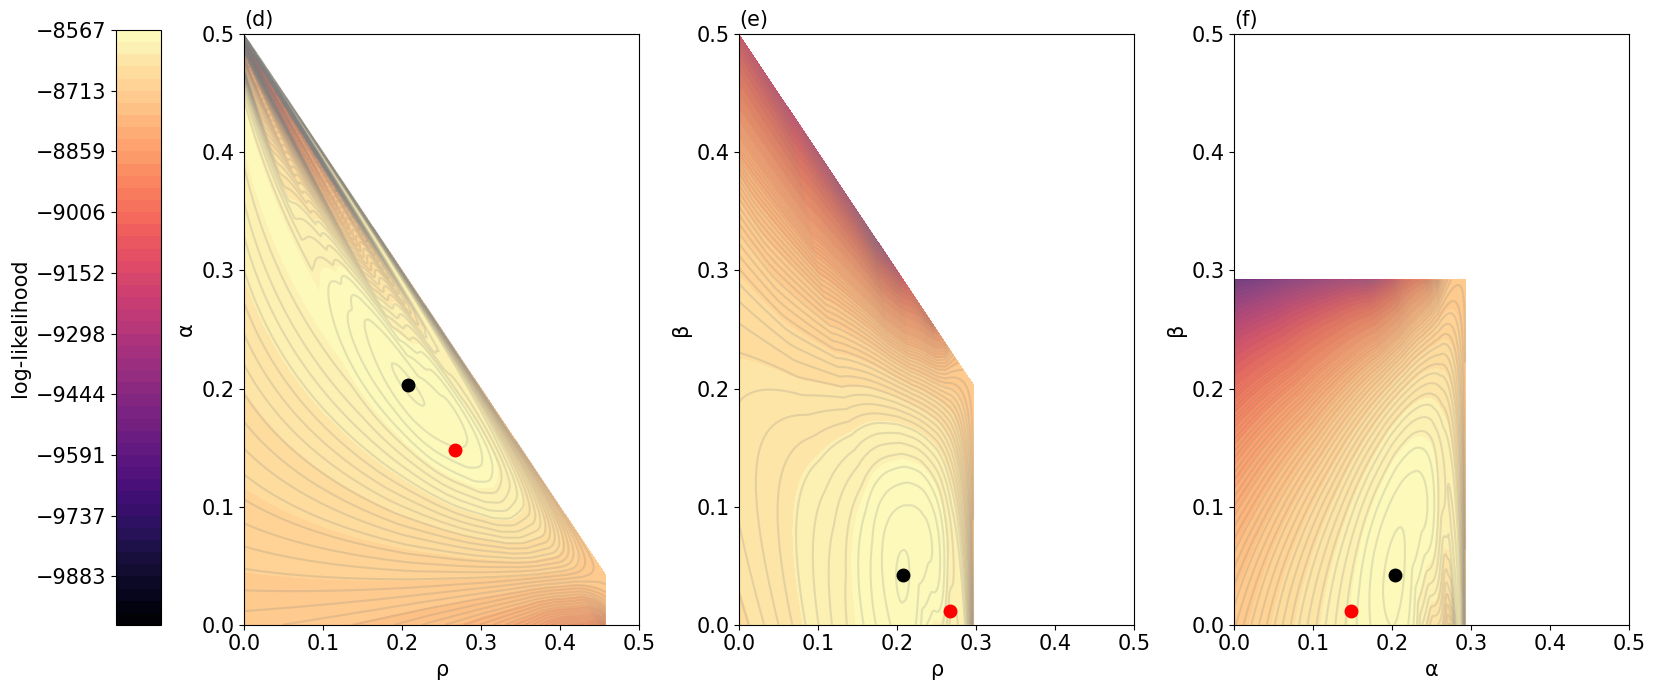

In [38]:
""" Contour plot """ 

cont_3D_M, axes = plt.subplots(1, 3, figsize= (15,7))

levels =np.linspace(-10000, grid_logs_3par_M.max())
levels_line = 100

ax = axes[0]
pco = ax.contourf(ρs, αs, grid_logs_3par_M[:,:,βs==θ_grid_3par_M[2]].squeeze().T, cmap=cont_color, levels=levels)
ax.contour(ρs, αs, grid_logs_3par_M[:,:,βs==θ_grid_3par_M[2]].squeeze().T,  colors=line_color, levels= levels_line, linestyles='solid', alpha= trans)
ax.plot(θ_grid_3par_M[0],θ_grid_3par_M[1], 'ok',markersize=marker_size_)
ax.plot(θ_1995[0],θ_1995[1], 'or',markersize=marker_size_)
ax.set(xlim=(0, 0.5), ylim=(0,0.5))
ax.set_xlabel('ρ', fontsize= font_size_)
ax.set_ylabel('α', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(d)',loc='left', size=font_size_)


ax = axes[1]
pco = ax.contourf(ρs, βs, grid_logs_3par_M[:,αs==θ_grid_3par_M[1],:].squeeze().T, cmap=cont_color, levels=levels)
ax.contour(ρs, βs, grid_logs_3par_M[:,αs==θ_grid_3par_M[1],:].squeeze().T,  colors=line_color, levels= levels_line, linestyles='solid', alpha= trans)
ax.plot(θ_grid_3par_M[0],θ_grid_3par_M[2],'ok', markersize=marker_size_)
ax.plot(θ_1995[0],θ_1995[2], 'or',markersize=marker_size_)
ax.set(xlim=(0, 0.5), ylim=(0,0.5))
ax.set_xlabel('ρ', fontsize= font_size_)
ax.set_ylabel('β', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(e)',loc='left', size=font_size_)


ax = axes[2]
pco = ax.contourf(αs, βs, grid_logs_3par_M[ρs==θ_grid_3par_M[0],:,:].squeeze().T, cmap=cont_color, levels=levels)
ax.contour(αs, βs, grid_logs_3par_M[ρs==θ_grid_3par_M[0],:,:].squeeze().T,  colors=line_color, levels= levels_line, linestyles='solid', alpha= trans)
ax.plot(θ_grid_3par_M[1],θ_grid_3par_M[2],'ok',markersize=marker_size_)
ax.plot(θ_1995[1],θ_1995[2], 'or', markersize=marker_size_)
ax.set(xlim=(0, 0.5), ylim=(0,0.5))
ax.set_xlabel('α', fontsize= font_size_)
ax.set_ylabel('β', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(f)',loc='left', size=font_size_)

cax = cont_3D_M.add_axes([-0.030, 0.1, 0.03, 0.85])
cbar = plt.colorbar(pco, cax=cax, label='log-likelihood')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize= tick_size_)
cbar.ax.set_ylabel('log-likelihood', fontsize= font_size_)


cont_3D_M.tight_layout()

#### 2D (rho,alpha)

In [39]:
grid_logL = np.zeros((pts, pts))

for i, ρ_ in enumerate(ρs):
    print(i, end=' ', flush=True)
    for j, α_ in enumerate(αs):
        θ_ = ρ_, α_
        grid_logL[i,j] = log_likelihood(θ_, D) 

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        try: 
            grid_logL[i,j] = grid_logL[i,j] 
        except Exception as e:
                print("Problem with", ρ_, α_, ":", e)
                grid_logL[i,j] = -np.inf

imax = np.unravel_index(np.argmax(grid_logL), grid_logL.shape) 
θ_grid = (ρs[imax[0]], αs[imax[1]], 0)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [40]:
θ_grid_2par_M = θ_grid
grid_logs_2par_M = grid_logL
grid_logs_2par_M_max = grid_logL.max()

In [41]:
# np.save(file='Grid_2D_M', arr= grid_logs_2par_M)

In [42]:
print("Grid 2D MLE estimate: \n")
print("logL={:.5f}".format(log_likelihood(θ_grid_2par_M, D)))
print("ρ={:.3f}, α={:.3f}, β=0".format(*θ_grid_2par_M))
print("α+ρ<0.5:",(θ_grid_2par_M[0]+θ_grid_2par_M[1])<0.5)
print("F_DL= {:.2f}%".format(compute_t(*θ_grid_2par_M)*100))

Grid 2D MLE estimate: 

logL=-8567.53352
ρ=0.239, α=0.172, β=0
α+ρ<0.5: True
F_DL= 13.51%


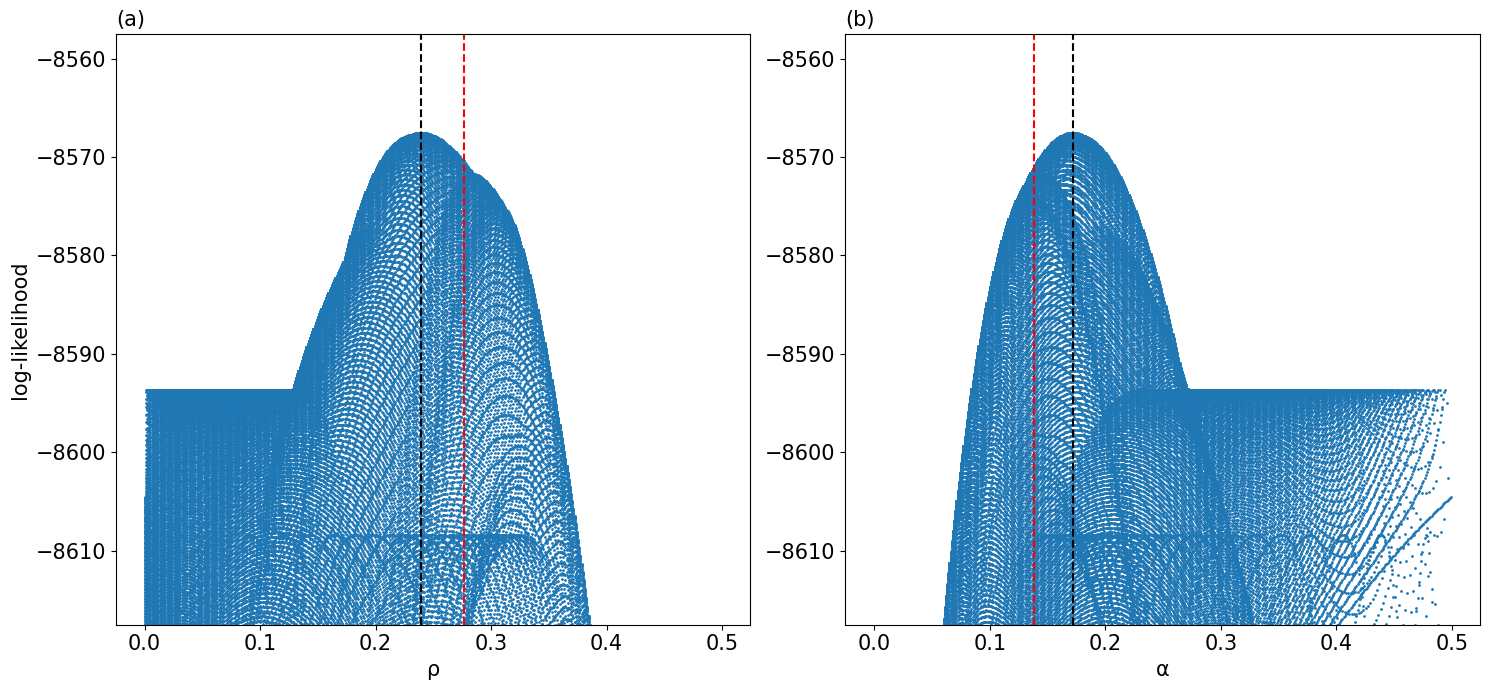

In [43]:
""" scatterplot """ 

scat_2D_M, axes = plt.subplots(1, 2, figsize= (15,7))

# rho
ax = axes[0]
ax.plot(grid_2D[1].ravel(), grid_logs_2par_M.ravel(), '.', markersize=2) 
ax.axvline(θ_grid_2par_M[0], color='k', ls='--')
ax.axvline(θ_19952d[0], color='r', ls='--')
ax.set_ylim(grid_logs_2par_M.max()-50, grid_logs_2par_M.max()+10)
ax.set_xlabel('ρ', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_ylabel('log-likelihood', fontsize= font_size_)
ax.set_title('(a)', loc='left', size=font_size_)

# alpha
ax = axes[1]
ax.plot(grid_2D[0].ravel(), grid_logs_2par_M.ravel(), '.', markersize=2) 
ax.axvline(θ_grid_2par_M[1],color='k', ls='--')
ax.axvline(θ_19952d[1], color='r', ls='--')
ax.set_ylim(grid_logs_2par_M.max()-50, grid_logs_2par_M.max()+10)
ax.set_xlabel('α', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize= tick_size_)
ax.set_title('(b)', loc='left', size=font_size_)

scat_2D_M.tight_layout()

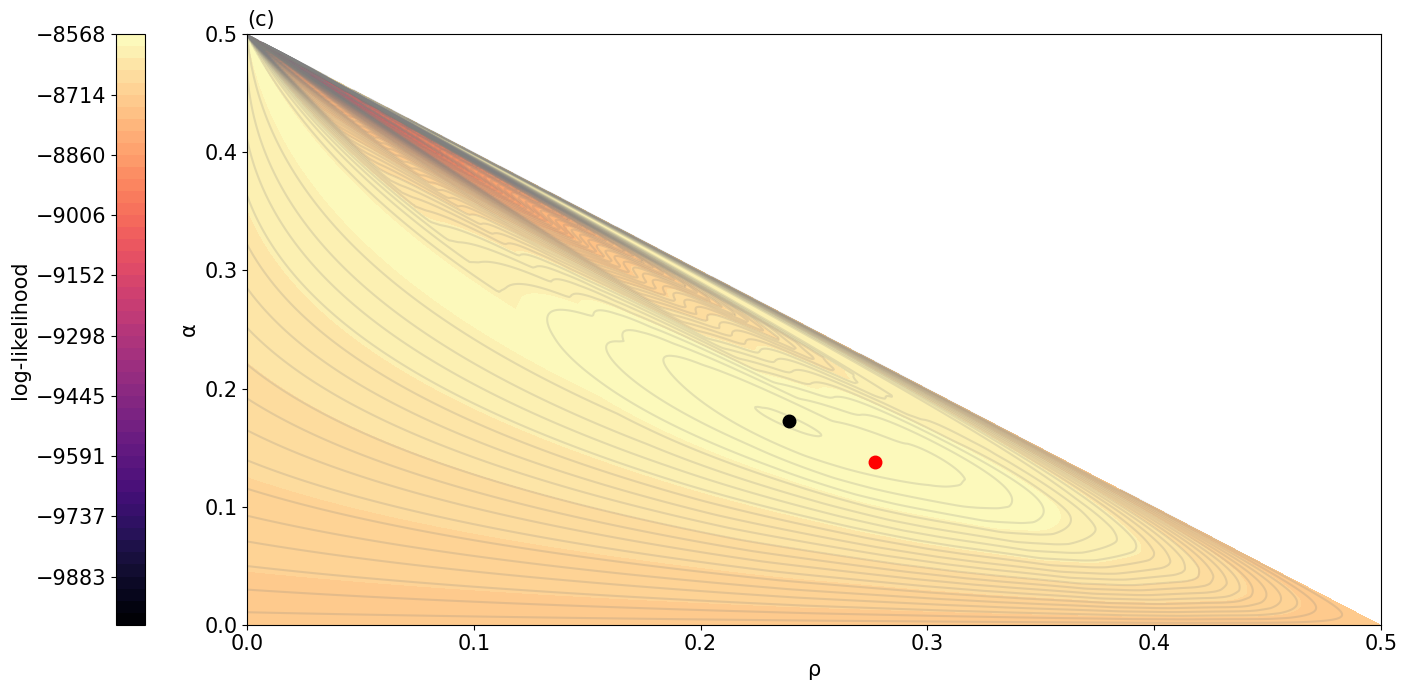

In [44]:
""" Contour plot """ 

cont_2D_M, axes = plt.subplots(1, figsize= (15,7))


levels =np.linspace(-10000, grid_logs_2par_M.max())
levels_line = 100

ax = axes
pco = ax.contourf(ρs, αs, grid_logs_2par_M[:,:,].squeeze().T, cmap=cont_color, levels=levels)
ax.contour(ρs, αs, grid_logs_2par_M[:,:,].squeeze().T, colors=line_color, levels= levels_line, linestyles='solid', alpha= trans)
ax.plot(θ_grid_2par_M[0],θ_grid_2par_M[1],'ok', markersize=marker_size_)
ax.plot(θ_19952d[0],θ_19952d[1],'or', markersize=marker_size_)
ax.set(xlim=(0, 0.5), ylim=(0,0.5))
ax.set_xlabel('ρ', fontsize= font_size_)
ax.set_ylabel('α', fontsize= font_size_)
ax.tick_params(axis= 'both', which = 'major', labelsize = tick_size_)
ax.set_title('(c)', loc='left', size = font_size_)

cbar = plt.colorbar(pco, label= 'log-likelihood', location='left', pad=0.07)
cbar.ax.tick_params(labelsize= tick_size_)
cbar.ax.set_ylabel('log-likelihood', fontsize = font_size_)


cont_2D_M.tight_layout()


In [45]:
print("I am done!")

I am done!
